In [ ]:
!git clone https://github.com/alinstein/Depth_estimation

Cloning into 'Depth_estimation'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 135 (delta 35), reused 73 (delta 16), pack-reused 40
Receiving objects: 100% (135/135), 140.28 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [ ]:
!ls

Depth_estimation  sample_data


In [ ]:
%cd Depth_estimation

/content/Depth_estimation


In [ ]:
import pandas as pd
import numpy as np
import torch
import os
from PIL import Image
from io import BytesIO
import random
from zipfile import ZipFile

from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.utils import shuffle
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from DepthData_mob import DepthDataset
from DepthData_mob import Augmentation
from DepthData_mob import ToTensor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
zf = ZipFile('/content/drive/MyDrive/NYUv2/nyu_data.zip', 'r')
zf.extractall('/content/drive/MyDrive/tmp')
zf.close()

KeyboardInterrupt: ignored

In [ ]:
# traincsv = shuffle(traincsv, random_state=0)
traincsv=pd.read_csv('/content/drive/MyDrive/tmp/data/nyu2_train.csv')
traincsv = traincsv.values.tolist()
traincsv = shuffle(traincsv, random_state=2)

0 (640, 480) (640, 480)


FileNotFoundError: ignored

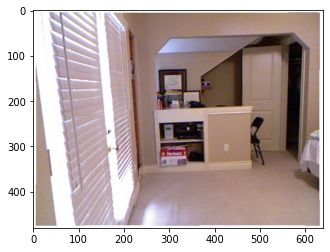

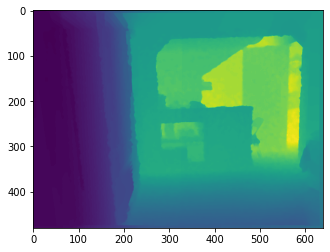

<Figure size 432x288 with 0 Axes>

In [ ]:
#display a sample set of image and depth image
depth_dataset = DepthDataset(traincsv=traincsv,root_dir='/content/drive/MyDrive/tmp/')
fig = plt.figure()
len(depth_dataset)
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]
    print(i, sample['image'].size, sample['depth'].size)
    plt.imshow(sample['image'])
    plt.figure()
    plt.imshow(sample['depth'])
    plt.figure()
    if i == 1:
        plt.show()
        break

In [ ]:
#testing code for trainloader

# depth_dataset = DepthDataset(traincsv=traincsv, root_dir='/workspace/',
#                 transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
# batch_size=4
# train_loader=torch.utils.data.DataLoader(depth_dataset, batch_size, shuffle=True)
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

In [ ]:
#loading the mobilNetDepth model
from Mobile_model import Model

In [ ]:
pip install kornia


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 551 kB 23.8 MB/s 


In [ ]:
import cv2
import kornia 

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    ssim = kornia.losses.SSIM(window_size=11,max_val=val_range,reduction='none')
    return ssim(img1, img2)

In [ ]:
import matplotlib
import matplotlib.cm
import numpy as np


def DepthNorm(depth, maxDepth=1000.0): 
    return maxDepth / depth

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def colorize(value, vmin=10, vmax=1000, cmap='plasma'):
    value = value.cpu().numpy()[0,:,:]

    # normalize
    vmin = value.min() if vmin is None else vmin
    vmax = value.max() if vmax is None else vmax
    if vmin!=vmax:
        value = (value - vmin) / (vmax - vmin) # vmin..vmax
    else:
        # Avoid 0-division
        value = value*0.
    # squeeze last dim if it exists
    #value = value.squeeze(axis=0)

    cmapper = matplotlib.cm.get_cmap(cmap)
    value = cmapper(value,bytes=True) # (nxmx4)

    img = value[:,:,:3]

    return img.transpose((2,0,1))

In [ ]:
def LogProgress(model, writer, test_loader, epoch):
    model.eval()
    sequential = test_loader
    sample_batched = next(iter(sequential))
    image = torch.autograd.Variable(sample_batched['image'].cuda())
    depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))
    if epoch == 0: writer.add_image('Train.1.Image', vutils.make_grid(image.data, nrow=6, normalize=True), epoch)
    if epoch == 0: writer.add_image('Train.2.Depth', colorize(vutils.make_grid(depth.data, nrow=6, normalize=False)), epoch)
    output = DepthNorm( model(image) )
    writer.add_image('Train.3.Ours', colorize(vutils.make_grid(output.data, nrow=6, normalize=False)), epoch)
    writer.add_image('Train.3.Diff', colorize(vutils.make_grid(torch.abs(output-depth).data, nrow=6, normalize=False)), epoch)
    del image
    del depth
    del output
    

In [ ]:
import time
import argparse
import datetime

import torch
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
from tensorboardX import SummaryWriter

# from data import getTrainingTestingData
# from utils import AverageMeter, DepthNorm, colorize

model = Model().cuda()
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)
#load trained model if needed
#model.load_state_dict(torch.load('/workspace/1.pth'))
print('Model created.')

epochs=50
lr=0.0001
batch_size=64

depth_dataset = DepthDataset(traincsv=traincsv, root_dir='/workspace/',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
train_loader=DataLoader(depth_dataset, batch_size, shuffle=True)
l1_criterion = nn.L1Loss()

optimizer = torch.optim.Adam( model.parameters(), lr )

# Start training...
for epoch in range(epochs):
    path='/workspace/'+str(epoch)+'.pth'        
    torch.save(model.state_dict(), path)
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)

    # Switch to train mode
    model.train()

    end = time.time()

    for i, sample_batched in enumerate(train_loader):
        optimizer.zero_grad()

        #Prepare sample and target
        image = torch.autograd.Variable(sample_batched['image'].cuda())
        depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))

        # Normalize depth
        depth_n = DepthNorm( depth )

        # Predict
        output = model(image)

        # Compute the loss
        l_depth = l1_criterion(output, depth_n)
        l_ssim = torch.clamp((1 - ssim(output, depth_n, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)

        loss = (1.0 * l_ssim.mean().item()) + (0.1 * l_depth)

        # Update step
       
        losses.update(loss.data.item(), image.size(0))
        loss.backward()
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log progress
        niter = epoch*N+i
        if i % 5 == 0:
            # Print to console
            print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t'
            'ETA {eta}\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})'
            .format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))

            # Log to tensorboard
            #writer.add_scalar('Train/Loss', losses.val, niter)
            
    path='/workspace/'+str(epoch)+'.pth'        
    torch.save(model.state_dict(), path)    
        if i % 300 == 0:
            LogProgress(model, writer, test_loader, niter)

    # Record epoch's intermediate results
    LogProgress(model, writer, test_loader, niter)
    writer.add_scalar('Train/Loss.avg', losses.avg, epoch)




Let's use 6 GPUs!
Model created.
Epoch: [0][0/792]	Time 19.918 (19.918)	ETA 4:22:54	Loss 0.5485 (0.5485)
Epoch: [0][5/792]	Time 1.786 (28.979)	ETA 0:23:25	Loss 0.7105 (0.7036)
Epoch: [0][10/792]	Time 1.760 (37.884)	ETA 0:22:55	Loss 0.6309 (0.6915)
Epoch: [0][15/792]	Time 1.818 (46.799)	ETA 0:23:32	Loss 0.5780 (0.6686)
Epoch: [0][20/792]	Time 1.745 (55.662)	ETA 0:22:27	Loss 0.5753 (0.6531)
Epoch: [0][25/792]	Time 1.780 (64.463)	ETA 0:22:45	Loss 0.5840 (0.6406)
Epoch: [0][30/792]	Time 1.800 (73.598)	ETA 0:22:51	Loss 0.5717 (0.6296)
Epoch: [0][35/792]	Time 1.796 (82.559)	ETA 0:22:39	Loss 0.5688 (0.6215)
Epoch: [0][40/792]	Time 1.754 (91.355)	ETA 0:21:59	Loss 0.5502 (0.6143)
Epoch: [0][45/792]	Time 1.744 (100.183)	ETA 0:21:42	Loss 0.5644 (0.6083)
Epoch: [0][50/792]	Time 1.772 (108.935)	ETA 0:21:54	Loss 0.5585 (0.6034)
Epoch: [0][55/792]	Time 1.756 (117.954)	ETA 0:21:34	Loss 0.5613 (0.5989)
Epoch: [0][60/792]	Time 1.754 (126.845)	ETA 0:21:23	Loss 0.5575 (0.5954)
Epoch: [0][65/792]	Time 1.83

In [ ]:
import torch.nn as nn

In [ ]:
#Evaluations

model = Model().cuda()
model = nn.DataParallel(model)
#load the model if needed
model.load_state_dict(torch.load('/content/drive/MyDrive/10.pth'))
model.eval()
batch_size=1

depth_dataset = DepthDataset(traincsv=traincsv, root_dir='/content/drive/MyDrive/tmp/',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
train_loader=DataLoader(depth_dataset, batch_size, shuffle=True)

for sample_batched1  in (train_loader):
    image1 = torch.autograd.Variable(sample_batched1['image'].cuda())
    
    outtt=model(image1 )
    break

    

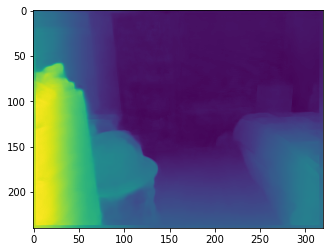

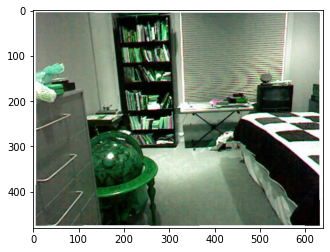

In [ ]:
#ploting the evaluated images

x=outtt.detach().cpu().numpy()
x.shape
x=x.reshape(240,320)
plt.imshow(x)
plt.figure()
plt.imshow(sample_batched1['image'].detach().cpu().numpy().reshape(3,480,640).transpose(1,2,0))

In [ ]:
for sample_batched1  in (train_loader):
    image1 = torch.autograd.Variable(sample_batched1['image'].cuda())
    
    outtt=model(image1 )
    break

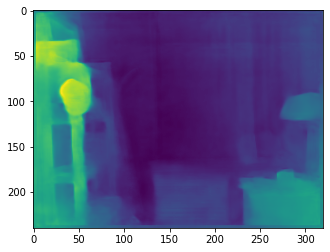

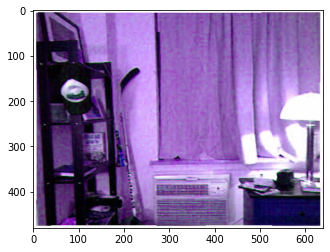

In [ ]:
#ploting the evaluated images

x=outtt.detach().cpu().numpy()
x.shape
x=x.reshape(240,320)
plt.imshow(x)
plt.figure()
plt.imshow(sample_batched1['image'].detach().cpu().numpy().reshape(3,480,640).transpose(1,2,0))

In [ ]:
pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 26.2 MB/s 


In [ ]:
import time
import argparse
import datetime

import torch
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
from tensorboardX import SummaryWriter

# from data import getTrainingTestingData
# from utils import AverageMeter, DepthNorm, colorize

model = Model().cuda()
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)
#load trained model if needed
#model.load_state_dict(torch.load('/workspace/1.pth'))
print('Model created.')

epochs=50
lr=0.0001
batch_size=64

depth_dataset = DepthDataset(traincsv=traincsv, root_dir='/workspace/',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
train_loader=DataLoader(depth_dataset, batch_size, shuffle=True)
l1_criterion = nn.L1Loss()

optimizer = torch.optim.Adam( model.parameters(), lr )



Model created.


In [ ]:
# Start training...
for epoch in range(epochs):
    path='/content/drive/MyDrive/tmp'+str(epoch)+'.pth'        
    torch.save(model.state_dict(), path)
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)

    # Switch to train mode
    model.train()

    end = time.time()

    for i, sample_batched in enumerate(train_loader):
        optimizer.zero_grad()

        #Prepare sample and target
        image = torch.autograd.Variable(sample_batched['image'].cuda())
        depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))

        # Normalize depth
        depth_n = DepthNorm( depth )

        # Predict
        output = model(image)

        # Compute the loss
        l_depth = l1_criterion(output, depth_n)
        l_ssim = torch.clamp((1 - ssim(output, depth_n, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)

        loss = (1.0 * l_ssim.mean().item()) + (0.1 * l_depth)

        # Update step
       
        losses.update(loss.data.item(), image.size(0))
        loss.backward()
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log progress
        niter = epoch*N+i
        if i % 5 == 0:
            # Print to console
            print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t'
            'ETA {eta}\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})'
            .format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))

            # Log to tensorboard
            #writer.add_scalar('Train/Loss', losses.val, niter)
            
    path='/content/drive/MyDrive/tmp'+str(epoch)+'.pth'        
    torch.save(model.state_dict(), path)
    if i % 300 == 0:
            LogProgress(model, writer, test_loader, niter)

    # Record epoch's intermediate results
    LogProgress(model, writer, test_loader, niter)
    writer.add_scalar('Train/Loss.avg', losses.avg, epoch)


FileNotFoundError: ignored